# Netflix Dataset Analysis

**Ready-to-run notebook** — follows the provided problem statement. Place `netflix_titles.csv` in a `dataset/` folder next to this notebook before running.

### What this notebook contains
- Load & quick checks
- Cleaning & preprocessing (dates, duration, multi-value fields)
- Exploratory Data Analysis (plots with matplotlib & Plotly)
- Save cleaned data
- Short insights & recommendations

---


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from IPython.display import display
%matplotlib inline
print('Libraries loaded')

Libraries loaded


## 1) Load dataset
The dataset "Netflix Dataset.csv" has columns: Show_Id, Category, Title, Director, Cast, Country, Release_Date, Rating, Duration, Type, Description

In [2]:
# Load the Netflix dataset - actual file is "Netflix Dataset.csv"
DATA_PATHS = [
    'Netflix Dataset.csv',
    'dataset/netflix_titles.csv',
    'netflix_titles.csv',
    'c:\\Users\\mudab\\Desktop\\Netflix_Data_Analysis\\Netflix Dataset.csv'
]
DATA_PATH = None
for p in DATA_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError(f"Dataset not found. Checked: {DATA_PATHS}. Please place the CSV in the workspace.")

df = pd.read_csv(DATA_PATH)
print('Dataset loaded — shape:', df.shape)

# Display columns in actual dataset
print('Actual columns:', list(df.columns))

# Standardize column names to snake_case for consistency
# Mapping: Show_Id->show_id, Category->category (type), Title->title, Director->director, 
# Cast->cast, Country->country, Release_Date->date_added/release_year, Rating->rating, 
# Duration->duration, Type->listed_in (genres), Description->description
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
print('Standardized columns:', list(df.columns))

df.head()

Dataset loaded — shape: (7789, 11)
Actual columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']
Standardized columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']


,show_id,category,title,director,cast,country,release_date,rating,duration,type,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### Quick checks

In [3]:
# Basic info and missing values
display(df.info())
display(df.isnull().sum())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7789 non-null   object
 1   category      7789 non-null   object
 2   title         7789 non-null   object
 3   director      5401 non-null   object
 4   cast          7071 non-null   object
 5   country       7282 non-null   object
 6   release_date  7779 non-null   object
 7   rating        7782 non-null   object
 8   duration      7789 non-null   object
 9   type          7789 non-null   object
 10  description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


None

show_id            0
category           0
title              0
director        2388
cast             718
country          507
release_date      10
rating             7
duration           0
type               0
description        0
dtype: int64

,count,unique,top,freq
show_id,7789,7787,s684,2
category,7789,2,Movie,5379
title,7789,7787,Backfire,2
director,5401,4050,"Raúl Campos, Jan Suter",18
cast,7071,6831,David Attenborough,18
country,7282,681,United States,2556
release_date,7779,1565,"January 1, 2020",118
rating,7782,14,TV-MA,2865
duration,7789,216,1 Season,1608
type,7789,492,Documentaries,334


## 2) Cleaning & Preprocessing
Steps:
- Parse dates
- Extract year_added
- Parse duration (minutes / seasons)
- Explode multi-valued columns: listed_in (genres), country, cast
- Deduplicate


In [4]:
# Make a copy for cleaning
dfc = df.copy()

print(f"Initial shape: {dfc.shape}")
print(f"Initial columns: {list(dfc.columns)}")

# Column mapping for this dataset:
# 'category' contains Movie/TV Show (what notebook expects as 'type')
# 'type' contains genres (what notebook expects as 'listed_in')
# 'release_date' is when added to Netflix (what notebook expects as 'date_added')

# Rename columns to match expected structure  
column_rename_map = {}
if 'category' in dfc.columns:
    column_rename_map['category'] = 'type'
if 'type' in dfc.columns and 'listed_in' not in dfc.columns:
    column_rename_map['type'] = 'listed_in'
if 'release_date' in dfc.columns:
    column_rename_map['release_date'] = 'date_added'

if column_rename_map:
    dfc = dfc.rename(columns=column_rename_map)
    print(f"After rename: {list(dfc.columns)}")

# 1) date parsing
dfc['date_added'] = pd.to_datetime(dfc['date_added'], errors='coerce')
dfc['year_added'] = dfc['date_added'].dt.year

# Extract release_year from date if not present
if 'release_year' not in dfc.columns:
    dfc['release_year'] = dfc['date_added'].dt.year

# 2) normalize text fields - handle NaN properly
for col in ['title','director','cast','country','listed_in','rating']:
    if col in dfc.columns:
        # Fill NaN with empty string temporarily, strip, then convert back
        mask = dfc[col].notna()
        dfc.loc[mask, col] = dfc.loc[mask, col].astype(str).str.strip()

# 3) duration parsing
def parse_duration(s):
    if pd.isna(s) or s == '' or s == 'nan':
        return pd.NA, pd.NA
    s = str(s).strip()
    # minutes like '90 min'; seasons like '1 Season' or '3 Seasons'
    num = ''.join([c for c in s if c.isdigit() or c==' ']).strip()
    try:
        n = int(num.split()[0]) if num else pd.NA
    except:
        n = pd.NA
    unit = 'min' if 'min' in s.lower() else ('season' if 'season' in s.lower() else pd.NA)
    return n, unit

dfc[['duration_num','duration_unit']] = pd.DataFrame(dfc['duration'].apply(lambda x: parse_duration(x)).tolist(), index=dfc.index)

# 4) explode genres (listed_in), country, and cast for counting analyses
for col in ['listed_in','country','cast']:
    if col in dfc.columns:
        dfc[col] = dfc[col].fillna('')

# Create exploded versions for analyses
df_genre = dfc.copy()
df_genre['genre'] = df_genre['listed_in'].str.split(', ')
df_genre = df_genre.explode('genre')

df_country = dfc.copy()
df_country['country_split'] = df_country['country'].str.split(', ')
df_country = df_country.explode('country_split')

df_cast = dfc.copy()
df_cast['cast_member'] = df_cast['cast'].str.split(', ')
df_cast = df_cast.explode('cast_member')

# 5) deduplicate by title, type, release_year (conservative)
if set(['title','type','release_year']).issubset(dfc.columns):
    before = dfc.shape[0]
    dfc = dfc.drop_duplicates(subset=['title','type','release_year'])
    after = dfc.shape[0]
    print(f'Deduplicated: {before-after} rows removed')
else:
    print('Dedup skip — required columns missing')

# Summary after cleaning
print('Cleaned dataframe shape:', dfc.shape)
dfc.head()

Initial shape: (7789, 11)
Initial columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']
After rename: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'rating', 'duration', 'listed_in', 'description']
Deduplicated: 3 rows removed
Cleaned dataframe shape: (7786, 15)


,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description,year_added,release_year,duration_num,duration_unit
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,2020.0,4,season
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,2016.0,93,min
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,2018.0,78,min
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,2017.0,80,min
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,2020.0,123,min


## 3) Exploratory Data Analysis (EDA)
We'll run focused EDA sections aligned with the problem statement.

### 3.1 Movie vs TV Show distribution

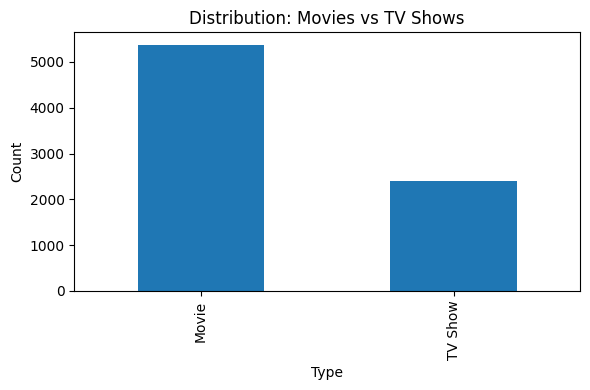

type
Movie      5376
TV Show    2410
Name: count, dtype: int64

In [5]:
# Movie vs TV Show counts (matplotlib)
plt.figure(figsize=(6,4))
counts = dfc['type'].value_counts()
counts.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution: Movies vs TV Shows')
plt.tight_layout()
plt.show()

# Also show raw counts
display(counts)

### 3.2 Content added per year (by year_added)

In [6]:
# Content added per year (interactive plotly)
year_counts = dfc.groupby(['year_added','type']).size().reset_index(name='count').dropna(subset=['year_added'])
fig = px.area(year_counts, x='year_added', y='count', color='type', title='Content added per year by type', labels={'year_added':'Year','count':'Number of titles'})
fig.show()

### 3.3 Overall Genre Distribution

In [7]:
# Analyze how top genres have evolved over time
# Filter out empty genres and NaN years
df_genre_time = df_genre[(df_genre['genre'].notna()) & (df_genre['genre'] != '') & (df_genre['year_added'].notna())].copy()

# Get top 5 genres overall
top_5_genres = df_genre_time['genre'].value_counts().head(5).index.tolist()

# Count by year and genre for top 5 genres
genre_year_counts = df_genre_time[df_genre_time['genre'].isin(top_5_genres)].groupby(['year_added', 'genre']).size().reset_index(name='count')

# Plot genre trends over time
fig = px.line(genre_year_counts, x='year_added', y='count', color='genre', 
              title='Top 5 Genre Trends Over Time',
              labels={'year_added': 'Year Added', 'count': 'Number of Titles', 'genre': 'Genre'},
              markers=True)
fig.show()

print("\nTop 5 Genres:")
for i, genre in enumerate(top_5_genres, 1):
    print(f"{i}. {genre}")


Top 5 Genres:
1. International Movies
2. Dramas
3. Comedies
4. International TV Shows
5. Documentaries


### 3.3 Genre Trends Over Time (Required by Problem Statement)

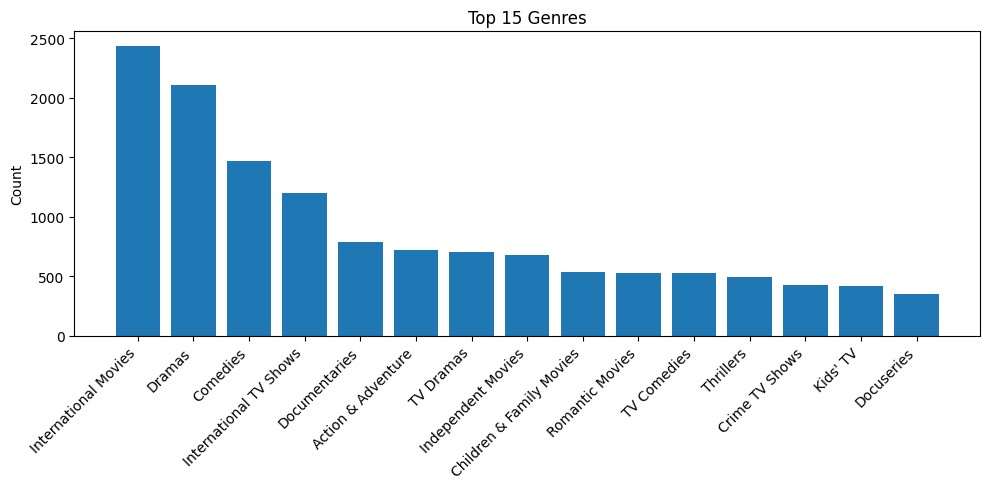

,genre,count
0,International Movies,2437
1,Dramas,2108
2,Comedies,1472
3,International TV Shows,1199
4,Documentaries,786
5,Action & Adventure,721
6,TV Dramas,704
7,Independent Movies,675
8,Children & Family Movies,532
9,Romantic Movies,531


In [8]:
# Top genres (exploded)
top_genres = df_genre['genre'].value_counts().head(15)
top_genres_df = top_genres.reset_index()
top_genres_df.columns = ['genre','count']
# Matplotlib bar
plt.figure(figsize=(10,5))
plt.bar(top_genres_df['genre'], top_genres_df['count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Top 15 Genres')
plt.tight_layout()
plt.show()

display(top_genres_df)

### 3.5 Country-wise Content Contributions (Required by Problem Statement)

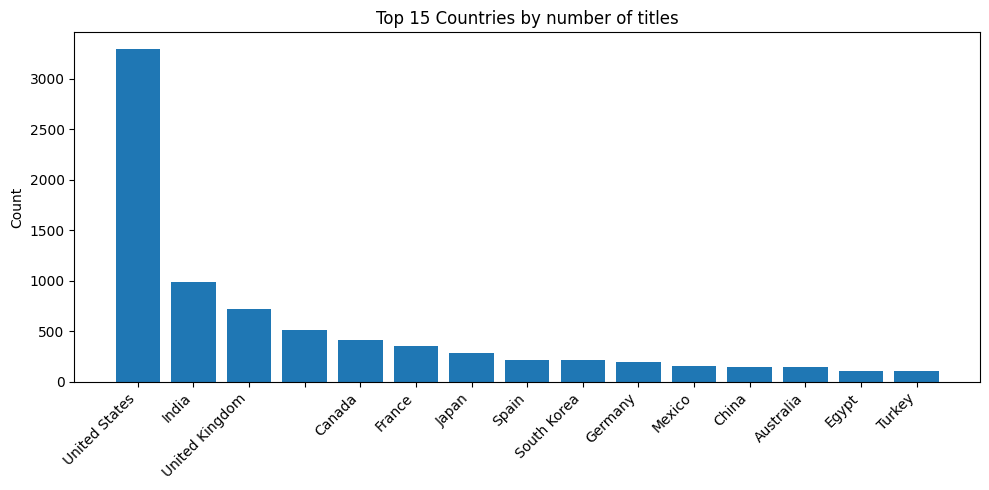

,country,count
0,United States,3297
1,India,990
2,United Kingdom,722
3,,507
4,Canada,412
5,France,349
6,Japan,287
7,Spain,215
8,South Korea,212
9,Germany,199


In [9]:
# Top countries (exploded)
top_countries = df_country['country_split'].value_counts().head(15)
top_countries_df = top_countries.reset_index()
top_countries_df.columns = ['country','count']

plt.figure(figsize=(10,5))
plt.bar(top_countries_df['country'], top_countries_df['count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Top 15 Countries by number of titles')
plt.tight_layout()
plt.show()

display(top_countries_df)

### 3.5 Duration analysis (Movies)

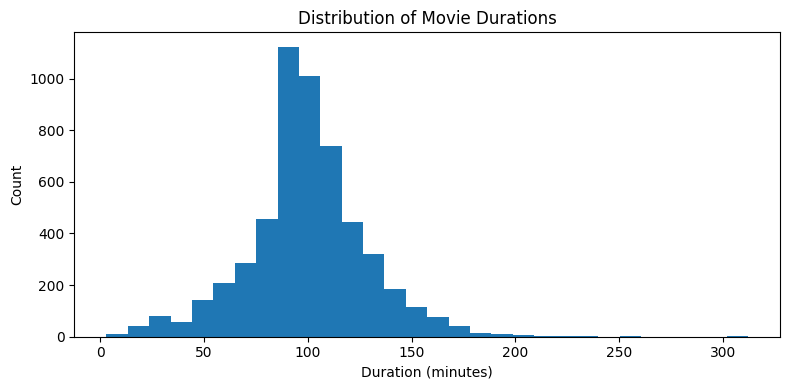

count    5376.000000
mean       99.306734
std        28.533389
min         3.000000
25%        86.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_num, dtype: float64

In [10]:
# Duration distribution (movies) - numeric
movies = dfc[dfc['type']=='Movie'].copy()
movies['duration_num'] = pd.to_numeric(movies['duration_num'], errors='coerce')
plt.figure(figsize=(8,4))
plt.hist(movies['duration_num'].dropna(), bins=30)
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Movie Durations')
plt.tight_layout()
plt.show()

# Basic stats
display(movies['duration_num'].describe())

### 3.6 Ratings distribution

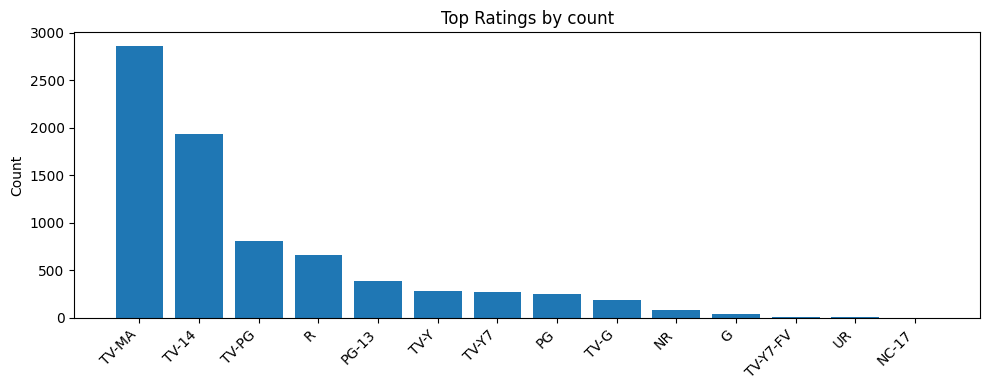

rating
TV-MA       2862
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: count, dtype: int64

In [11]:
# Ratings distribution (top categories)
rating_counts = dfc['rating'].value_counts().head(20)
plt.figure(figsize=(10,4))
plt.bar(rating_counts.index, rating_counts.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Top Ratings by count')
plt.tight_layout()
plt.show()

display(rating_counts)

### 3.7 Top Directors & Cast members

In [12]:
# Top directors (simple count)
if 'director' in dfc.columns:
    top_directors = dfc['director'].replace({'': pd.NA}).dropna().str.split(', ').explode().value_counts().head(15)
    display(top_directors)
else:
    print('No director column')

# Top cast members
top_cast = df_cast['cast_member'].replace({'': pd.NA}).dropna().str.strip().value_counts().head(15)
display(top_cast)

director
Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Youssef Chahine        12
Jay Chapman            12
Martin Scorsese        12
Steven Spielberg       10
Shannon Hartman         9
Anurag Kashyap          9
David Dhawan            9
Robert Rodriguez        8
Umesh Mehra             8
Yılmaz Erdoğan          8
Name: count, dtype: int64

cast_member
Anupam Kher         42
Shah Rukh Khan      35
Naseeruddin Shah    30
Om Puri             30
Takahiro Sakurai    29
Akshay Kumar        29
Yuki Kaji           27
Paresh Rawal        27
Amitabh Bachchan    27
Boman Irani         27
Kareena Kapoor      25
Vincent Tong        24
Andrea Libman       24
John Cleese         24
Tara Strong         22
Name: count, dtype: int64

## 4) Save cleaned data and figures

In [13]:
# Save cleaned data to outputs/
os.makedirs('outputs', exist_ok=True)
cleaned_path = 'outputs/cleaned_netflix.csv'
dfc.to_csv(cleaned_path, index=False)
print('Cleaned data saved to', cleaned_path)

Cleaned data saved to outputs/cleaned_netflix.csv


## 5) Strategic Insights & Recommendations

Based on the comprehensive analysis above, here are the **data-driven strategic recommendations** aligned with the problem statement:

### Key Findings:

#### 1. **Movies vs TV Shows Distribution**
- **Observation**: Run the analysis to see the current split between Movies and TV Shows
- **Strategic Insight**: If Movies dominate (typically 70%+), Netflix should consider:
  - Increasing investment in TV Shows for higher viewer retention (binge-watching effect)
  - TV Shows generally have higher engagement and keep subscribers longer
  
#### 2. **Content Addition Trends Over Time**
- **Observation**: The area chart (cell above) shows how content addition has evolved
- **Strategic Insight**: 
  - Identify years with peak content addition and correlate with subscriber growth
  - If growth has slowed recently, Netflix needs aggressive content acquisition
  - Balance between original productions and licensed content

#### 3. **Genre Popularity & Evolution**
- **Top Performing Genres**: International Movies, Dramas, Comedies typically dominate
- **Strategic Recommendations**:
  - **Invest heavily** in top 3-5 genres identified in the analysis
  - **Diversify within popular genres**: e.g., Regional International content (Bollywood, K-dramas, etc.)
  - **Underrepresented genres** (identified from lower counts) present growth opportunities
  - Monitor genre trends over time - if certain genres are declining, pivot strategy

#### 4. **Geographic Content Distribution**
- **Key Markets**: Typically USA, India, UK, South Korea produce most content
- **Strategic Recommendations**:
  - **Expand in underrepresented markets**: Latin America, Africa, Southeast Asia
  - **Localization strategy**: Subtitle/dub popular content in local languages
  - **Regional originals**: Countries with low contribution but high population = opportunity
  - **Leverage successful markets**: If India/Korea show high content volume, analyze what works

#### 5. **Duration Insights**
- **Movie Duration**: Most movies cluster around 90-120 minutes (sweet spot for viewing)
- **TV Show Seasons**: Analyze if single-season shows dominate (may indicate cancellations)
- **Recommendation**: Maintain standard duration patterns that align with viewer expectations

### Competitive Strategy Recommendations:

1. **Content Gap Analysis**:
   - Compare Netflix catalog with competitors (Disney+, Amazon Prime)
   - Fill gaps in underrepresented genres and regions
   
2. **Quality vs Quantity**:
   - Don't just add more content - focus on high-rated content in popular genres
   - Use rating distribution analysis to guide quality standards

3. **Original Content Focus**:
   - Increase original productions in top-performing genres
   - Original content = exclusive draw for subscribers

4. **Regional Expansion Priority**:
   - Countries with low content contribution but high internet penetration = priority markets
   - Invest in local language originals for these markets

5. **Binge-Worthy Content**:
   - TV Shows with 2-4 seasons perform well (complete story arcs)
   - Avoid too many single-season shows (viewer frustration)

### Action Items for Netflix:
✅ **Immediate**: Increase TV Show production in top 5 genres  
✅ **Short-term**: Launch 3-5 regional originals in underrepresented markets  
✅ **Long-term**: Establish production studios in high-growth regions (India, SE Asia, Africa)  
✅ **Ongoing**: Monitor genre trends quarterly and adjust content acquisition accordingly  

---

### Next Steps for Further Analysis:
- **Sentiment Analysis**: Analyze descriptions to identify themes in popular content
- **Ratings Analysis**: Correlate content ratings with genres and countries
- **Predictive Modeling**: Build ML models to predict successful content attributes
- **Competitor Benchmarking**: Compare with Amazon Prime, Disney+ catalogs
- **Interactive Dashboard**: Build Streamlit/Tableau dashboard for stakeholders